In [37]:
import warnings
import umap
import torch

import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn import decomposition, preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from collections import Counter
from scipy import stats
from scipy.spatial import distance
from annoy import AnnoyIndex

from IPython.display import display, Markdown
from torch.nn import functional as F

from news_vec.encoder import read_preds

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [3]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 200

In [77]:
df, embeds = read_preds('../data/ava-lstm-attn/')

100%|██████████| 283/283 [00:15<00:00, 18.63it/s]


In [78]:
df_train = df[df.split=='train']

In [79]:
DOMAINS = df.domain.unique()

In [80]:
DOMAINS

array(['breitbart.com', 'cnn.com', 'nytimes.com', 'bloomberg.com',
       'dailycaller.com', 'apnews.com', 'buzzfeed.com',
       'washingtonpost.com', 'huffingtonpost.com', 'foxnews.com',
       'wsj.com', 'npr.org', 'msnbc.com', 'thehill.com', 'dailykos.com'],
      dtype=object)

In [81]:
embeds.shape

(282120, 512)

In [82]:
df['wc'] = df.clf_tokens.apply(lambda ts: len(ts))

In [83]:
idx = AnnoyIndex(embeds.shape[1])

for i, v in tqdm(enumerate(embeds)):
    idx.add_item(i, v)
    
idx.build(20)

282120it [00:22, 12641.64it/s]


True

In [84]:
c1 = df_train[(df_train.domain=='foxnews.com')&(df_train.windows.apply(lambda ws: any(np.array(ws) < 10)))]
c2 = df_train[(df_train.domain=='foxnews.com')&(df_train.windows.apply(lambda ws: any(np.array(ws) > 80)))]

In [85]:
d = embeds[c2.index].mean(0) - embeds[c1.index].mean(0)

In [86]:
for i in idx.get_nns_by_vector(d, 20):
    print(df.iloc[i].clf_tokens)

['four', 'missouri', 'children', 'locked', 'in', 'boxes', 'secured', 'with', 'plywood', 'and', 'screws', 'cops', 'say', '#', 'arrested']
['nervous', 'dog', 'escapes', 'crate', 'forces', 'emergency', 'landing', 'by', 'tearing', 'inner', 'lining', 'of', 'luggage', 'compartment']
['california', 'sikh', 'man', 'heinously', 'attacked', 'while', 'placing', 'road', 'signs', 'for', 'gop', 'congressman', 'police', 'say']
['brett', 'kavanaugh', 'vows', 'to', 'keep', 'an', 'open', 'mind', 'in', 'every', 'case', 'after', 'chaotic', 'confirmation', 'hearing', 'day']
['teens', 'arrested', 'in', 'massachusetts', 'for', 'allegedly', 'having', 'sex', 'on', 'beach', 'while', 'crowd', 'watched', 'cheered', 'on']
['will', 'rosie', 'odonnell', 'be', 'held', 'to', 'same', 'standard', 'as', 'dinesh', 'dsouza', 'after', 'reportedly', 'exceeding', 'donation', 'limit']
['tennessee', 'teacher', 's', 'petty', 'note', 'restricting', 'bathroom', 'and', 'nurse', 'breaks', 'goes', 'viral', 'sparks', 'outrage']
['high

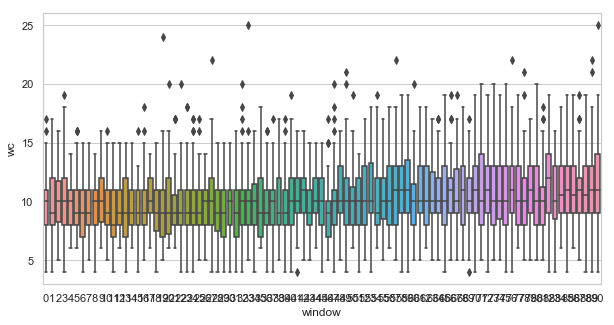

In [57]:
pdf = df[df.domain=='foxnews.com']
plt.figure(figsize=(10,5))
sns.boxplot(x='window', y='wc', data=pdf)
# plt.scatter(pdf.window, pdf.wc, s=1)